### Introduction to clustering

Clustering is an unsupervised machine learning technique that allows you to get insights about your data without the need of labels. It allows you find structure in a set of data points and allows you to group similar datapoints together. The output is represented as a plot that shows the clusters that each data point belogs to. Here is an example:


source: [Wikipedia](https://en.wikipedia.org/wiki/Cluster_analysis)

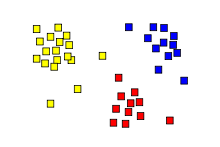

In the above image, there are three distinct clusters that the data points are divided into. There is no set way to define the cluster requirements. It relies on the method chosen by the clustering algorithms to find the data points that are most similar and group them into a pre defined number of groups. The closer the datapoint to the center of the cluster, the stronger are its similarities to the others in the same cluster. The further it moves away from the center, the lesser are its similarities. There are ways to choose the appropriate number of clusters, which we will discuss in the next and final section of the workshop. For now, we will assume a predifined number of clusters for our problem.

### K-means clustering
k-means clustering algorithm attempts to partition a given set of data points to minimize the variance of the points in the partition.

Given a set of data points $(x_1,x_2,x_3,....,x_n)$ , the algorithm aims to partition(cluster) these data points into $k$ clusters $(k<n)$ such that the sum of squared avarages (variance) of the points in the cluster is minimized.

If we represent the clusters as $(c_1,c_2,c_3,....,c_k)$, and $\gamma$ is the mean of all points in a cluster, then the alogorithm attempts to find

$\min\sum_{i=1}^k\sum_{x\in c_i}\parallel x-\gamma_i\parallel^2$

where $\parallel x-\gamma_i\parallel^2$ is the variance of point $x$ in the cluster.

### Problem definition
As we saw in the previous notebook, the dataset we are working with has 5 adverse event topics for each drug name that were generated from unstructured descriptions of those adverse events. Given these unstructured descriptions as the only source of information about the drug, we want to cluster these drugs into groups based on how similar they are in terms of the adverse events that are associated with them. This means if two drugs result in similar adverse events, they will be grouped together. We will do this by using the K-means clustering algorithm described above.
<br><br>Adverse events are reported in free text and this type of unsupervised grouping of drugs based on unstructured descriptions of adverse events  will allow analysts to better understand the adverse events patterns in groups of drugs just from raw unstructured data. Its valuable input for further studies involving supervised techniques like classification or regression.

### Setup

We will begin by importing the necessary libraries into our notebook. **Note that [gensim](https://radimrehurek.com/gensim/) and [columnize](https://pypi.org/project/columnize/) doesnt come preinstalled with the SageMaker Notebook.** The library is preinstalled for you using a [SageMaker lifecycle configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-lifecycle-config.html) that was attached to the notebook instance at the time it was created using a [CloudFormation template](https://aws.amazon.com/cloudformation/resources/templates/).


In [23]:
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import get_execution_role
import boto3, os
import pandas as pd
import gensim                                     
import columnize
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

Next, we will create a SageMaker session to manage interactions with SageMaker commands and other AWS services. We use this session to create a sagemaker default bucket, an S3 bucket in your AWS account that allows you to store training data, model arctifacts and other supporting files. We also get the sagemaker execution role and our s3 prefix for storing the files.

In [2]:
sagemaker_session=sagemaker.Session()
bucket = sagemaker_session.default_bucket()

role = get_execution_role()
prefix = 'sagemaker/ae-clustering'

print('Training input/output will be stored in {}/{}'.format(bucket, prefix))
print('\nIAM Role: {}'.format(role))

Training input/output will be stored in sagemaker-us-east-2-127132734718/sagemaker/ae-clustering

IAM Role: arn:aws:iam::127132734718:role/mod-83a1651648cc4a4c-SagemakerRole-DER0JEVP4NTK


### Data analysis and pre processing
Lets now load up our data file into a data frame by using the [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) command of Pandas. While we generated multiple files in the previous notebook, let's select the file `reviews_all.csv`, which contains all of the reviews generated previously.

In [3]:
raw_data = pd.read_csv("source/reviews_all.csv")
display(raw_data)

,drugName,topic1,topic2,topic3,topic4,topic5
0,Levonorgestrel,drowsy,UTI,tired,burns,drowsy
1,Differin,acne,pimples,Pimples,acne,pimples
2,Ethinyl estradiol / norethindrone,light period,anxiety,depression,sexually active,anxiety
3,Invokana,itchy,lost about 17 pounds,feel sooo much better,itchy,lost about 17 pounds
4,Leuprolide,depression,mood swings,mood swings,mood swings,side effects
5,Varenicline,dry mouth,constipation,dry mouth,bronchitis,sleepy
6,ParaGard,pain,pain,pain,fully gone away,pain
7,Copper,nulliparous,nulliparous,spotting,nulliparous,spotting
8,Gabapentin,pain,gas,shingles,tingling,shingles
9,Trintellix,depression,confusion,depression,depression,confusion


Next, we drop the column "drugName" from the source dataframe and store the other columns in a new dataframe "raw_sentences". This is because we want to save the original dataframe for analyzing our output from the model. We then create a list of terms in columns "topic1" through "topic5" and save it in a new variable called "corpus". This variable contains a list of topics for all the drugs in our source data. You can see how the corpus looks for the first drug by printing the first row of the corpus (denoted by index 0).  

In [4]:
raw_data.head(1)

,drugName,topic1,topic2,topic3,topic4,topic5
0,Levonorgestrel,drowsy,UTI,tired,burns,drowsy


In [5]:
raw_sentences=raw_data.drop(['drugName'], axis=1)
corpus = raw_sentences.values.tolist()
corpus[0]

['drowsy', 'UTI', 'tired', 'burns', 'drowsy']

## Generating word embeddings and vocabulary

Word embedding is a technique that allows words present in a corpus to be represented as a vector of real numbers with a fixed number of dimensions. This technique is invaluable for [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) tasks as it allows algorithms to learn complex assiciations and context in a corpus of words. This allows you to answer questions like "how similar/different is one word to the other word?"<br><br> We will use the [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) algorithm from the Gensim library to generate real valued vector representations for our corpus of words. The vectors have 100 dimensions and the algorithm automatically generates the unique vocabulary for us. 

In [8]:
# traing wordtovec model on diagnosis description tokens
word_vec = Word2Vec(corpus,iter = 50)

ae_words = list(word_vec.wv.vocab)
#print(columnize.columnize(ae_words, displaywidth=80, ljust=False))

As you took a subsample of the total review, each run through the workshop may generate a slightly different number of words in the vocabulary. The above model for all reviews has 4829 words in the vocabulary. You can get your number by checking the length of our vocabulary variable "ae_words"

In [7]:
len(ae_words)

4815

In [11]:
len(word_vec.wv.vocab)

4815

### How do we visualize these embeddings?
Embeddings are much more intuitive when you can visualize them in a two dimensional plot. It allows you to view your vocabulary and see how closely they are associated with other words in the vocabulary.<br><br> To visualize vectors in a two dimensonal space, we perform the following steps:
1. Reduce the number of dimensions in our source data to two. Remember that the Word2Vec algorithm generates a vector with a 100 dimensions. We need to bring that down to two so it can be plotted on the X and Y axis.
2. Represent these two dimensional data points so that it maintains original pair wise association within the vocabulary. This allows words similar to each other to appear closer in two diemnsional space.

To address the above conditions, we use a techniqe called [t-distributed stochastic neighbour embedding or t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). The algorithm attempts to take high dimensional data sets and represents them in two dimensions so that objects that are similar are represented by nearby points and objects that are dissimilar are represented by distant points with high probability.<br><br>
For our implementation, we chose the [TSNE algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) from the sklearn.manifold library. The below code block creates two arrays, the first one is called "labels" and it stores each word occurring in our vocabulary. The second array "tokens" stores the high dimensional vector representations of each word in the vocabulary. This second array is passed to the t-SNE algorithm to get a two dimensional representation of the coordinates computed by the t-SNE algorithm. This is stored into two arrays x and y. Finally, the code generates a scatter plot for (x,y) pairs with labels stored in the "labels" array.<br><br>
For the purposes of our visualization, we will take **100 words** from our vocabulary and visulize them in a scatter plot.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


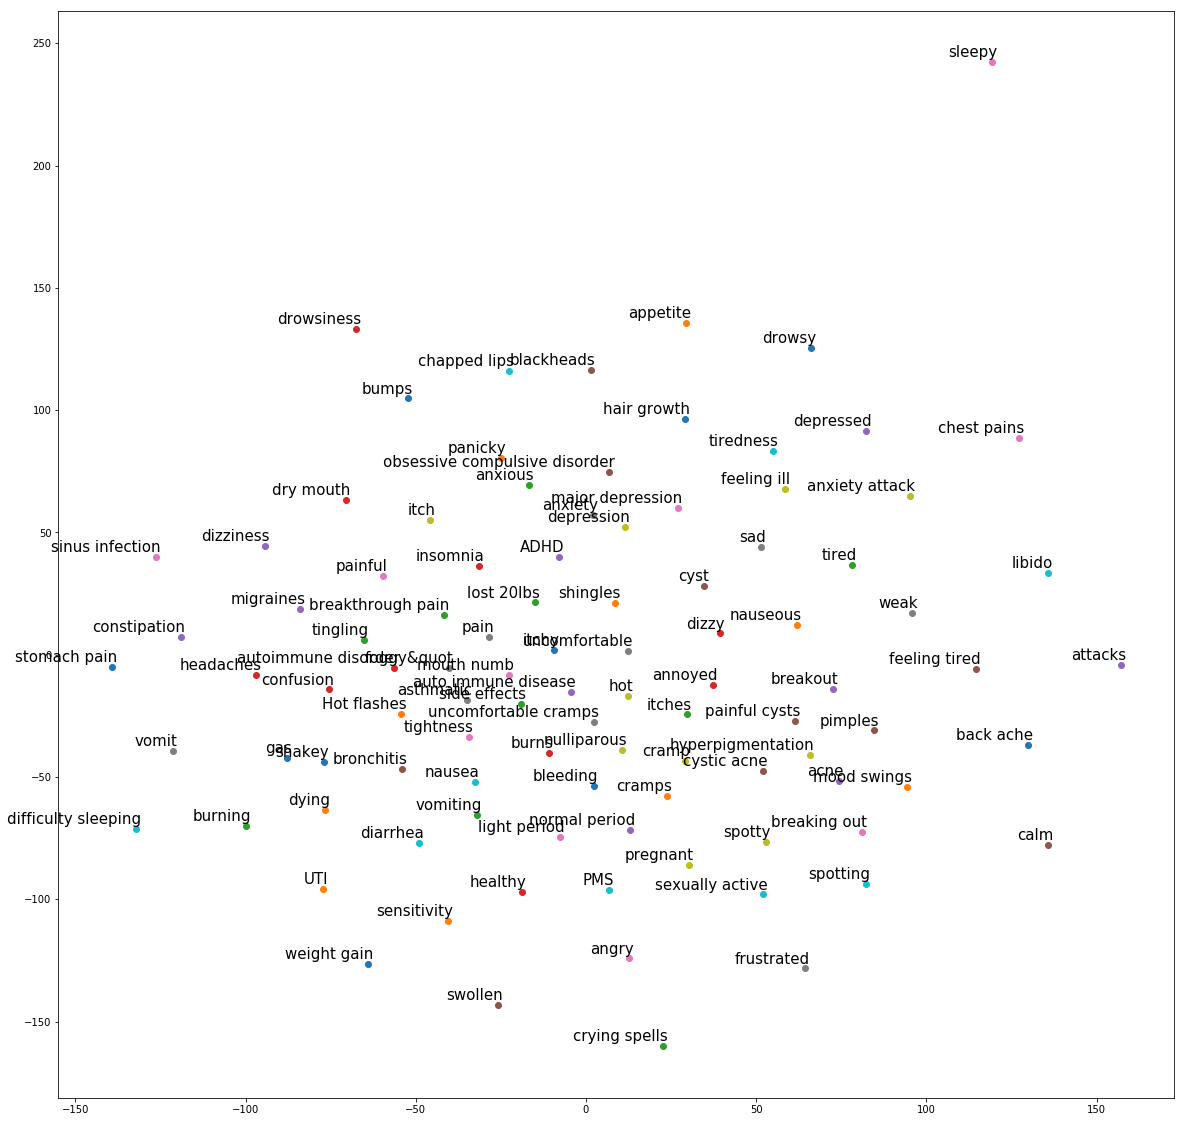

In [10]:
labels = []
tokens = []
i=1

for word in word_vec.wv.vocab:
        tokens.append(word_vec[word])
        labels.append(word)
        i += 1 
        if i==100:
            break
        
    
tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=500, random_state=10)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(20, 20)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                fontsize=15)
plt.show()

### Understanding the T-SNE Plot
As described above, the plot provides a visual representation of the adverse reactions of drugs in a 2 dimensional space. The closer the terms are to each other, the more related they are. This allows you to see how the vocabulary is distributed overall. Lets zoom in to the plot and example some terms.

Screen Shot 2019-11-21 at 3.34.45 PM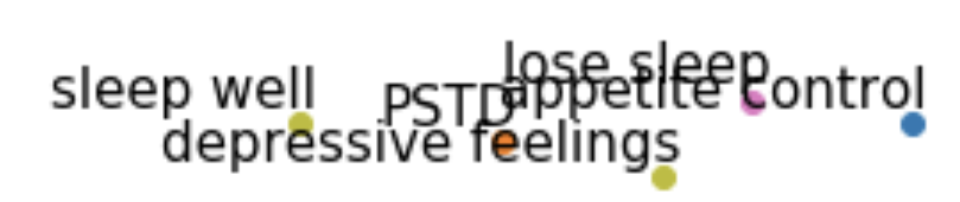

In the above, all sleep realted problems are appearing close to each other as they are closely realted. Zoom in on other parts of the plot and look at the various terms and how they appear on the plot. 
<br><br>
Now that we have generated our word embeddings using the gensim Word2Vec algorithm, we can make use of functions like "similar_to" to find all terms in our vocabulary that are similar to a certain term. Here is an example of all terms similar to "UTI"

In [16]:
word_vec.most_similar('angry')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('feeling even better', 0.6893447637557983),
 ('odour', 0.627814531326294),
 ('horrible depression', 0.6203708648681641),
 ('irregular', 0.6037831902503967),
 ('sob', 0.5967915058135986),
 ('feeling drunk', 0.5833702087402344),
 ('good eating habits', 0.5759549140930176),
 ('light flow', 0.5493993759155273),
 ('lack of a better word', 0.5325818657875061),
 ('gained 60 pounds', 0.5300302505493164)]

Try replacing UTI with other terms in the vocabulary and see the results.
<br><br>
Recall that the embeddings are vector representations of a word in a vocabulary. The model above stores these vectors as numpy arrays. We create a list of arrays for each word in our vocabulary in the variable "vecs"

In [17]:
vecs = []
for word in word_vec.wv.vocab:
        vecs.append(word_vec[word])


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


Here is how a single word is represented in our list of vectors.

In [18]:
vecs[0]

array([ 9.07588124e-01,  1.47819531e+00,  2.67478377e-02,  3.74435961e-01,
        1.45248365e+00,  8.33957255e-01, -6.48939729e-01, -4.29975659e-01,
       -4.19411868e-01,  9.79072452e-01, -1.43034911e+00,  4.58936661e-01,
        1.01703751e+00, -8.03474128e-01, -1.24649978e+00, -3.58475298e-01,
        2.80661678e+00,  1.21698296e+00, -1.22163987e+00, -4.92881626e-01,
       -1.28034079e+00, -1.50068891e+00, -1.05670318e-02, -5.34757972e-01,
        2.33546758e+00,  1.34346330e+00, -3.77161086e-01,  2.41193247e+00,
       -6.14455700e-01,  1.20793557e+00, -4.85029668e-02, -1.55860555e+00,
       -3.32987994e-01,  4.74588126e-01, -9.24386382e-01, -5.05827852e-02,
       -7.29447305e-01,  3.88087958e-01, -1.15643125e-02, -2.11532146e-01,
        6.56271756e-01,  1.52835846e+00,  1.25307357e+00,  6.56719625e-01,
       -1.38133550e+00, -1.06966384e-01, -5.14337897e-01,  1.89581537e+00,
        2.84216166e-01, -6.62704408e-01,  3.04225147e-01,  1.04352391e+00,
       -1.04039264e+00, -

Now that we have our list of vectors, let's save it in a CSV file. We will use this file for training our k-means clustering algorithm. Note that because it is an unsupervised learning technique, we do not split the data into train and test. Instead, we use the same data to train a clustering model and for inference. During inference, the model returns a cluster label for each row in our dataset which allows us to group them together. To avoid any confusion, we create two variables: train_input for training and transform_input for inference. Note that both of them point to the same file on S3. 

In [19]:
np.savetxt("vectors.csv", vecs, delimiter=",")
train_input = sagemaker_session.upload_data(path='vectors.csv', key_prefix='scikit-kmeans/data')
transform_input = sagemaker_session.upload_data(path='vectors.csv', key_prefix='scikit-kmeans/data')
print(train_input)
print(transform_input)
print(train_input == transform_input)

s3://sagemaker-us-east-2-127132734718/scikit-kmeans/data/vectors.csv
s3://sagemaker-us-east-2-127132734718/scikit-kmeans/data/vectors.csv
True


## SageMaker Training
We will use SageMaker script mode to run our training. Script mode allows you to bring a training script and run it on Sagemaker with little modification. SageMaker runs this training in a container on an external instance and returns a trained model that can then be used for inference. The choice of container depends on the library being used in training. The library we are using for our training is Scikitlearn. Hence, SageMaker will run our training on [SageMaker Scikitlearn container](https://github.com/aws/sagemaker-scikit-learn-container). SageMaker also has similar containers for MxNet, TensorFlow and Pytorch. For reference, please look at the following link: https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html
<br><br>
We have prepared a python training script for our use case called "condition_cluster.py" Lets see the script in more detail. 

In [12]:
! cat condition_cluster.py

import argparse
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.preprocessing import Normalizer
import numpy as np

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # Hyperparameters are described here. In this simple example we are just including one hyperparameter.
    parser.add_argument('--n_clusters', type=int, default=2)
    parser.add_argument('--random_state', type=int, default=0)
    
    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()
    
    input_files = [ os.path.join(args.train, file) for file in os.listdir(args.train) ]
    if len(input_files) == 0:
     

The script above parses the arguments that are used for training the model, trains the model and then saves it in the path model_dir. This is a default environment variable SM_MODEL_DIR that Sagemaker providess to be used in our training script. Similarly, Sagemaker provides environement variables for loading the input training data (SM_CHANNEL_TRAIN) and storing the model data during training (SM_OUTPUT_DATA_DIR). For a full list of environment variables, please look at the following link: https://github.com/aws/sagemaker-containers#important-environment-variables
<br><br>
These variables are handy to interact with the remote training container thats executing your training script.
<br><br>
The script also contains a function called model_fn. This function is reponsible for loading the trained model from the disk and making it ready for inference.
<br><br>
Let us now create a [Sagemaker Scikitlearn estimator](https://sagemaker.readthedocs.io/en/stable/sagemaker.sklearn.html) object using our script.

In [26]:
script_path = 'condition_cluster.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'n_clusters': 3, 'random_state':0})

The estimator sklearn excepts the following parameters:
* entry_point: The path to our training script
* train_instance_type: The instance on which the Sagemaker will execute our training.
* role: The role that will be used to run our training. This allows Sagemaker to determine if the user has permissions to run Sagemaker training.
* sagemaker_session: The Sagemaker session using which Sagemaker executes the commands.
* hyperparameters: A dictionary of hyperparameters that is used by Sagemaker training.


**Note that we have hard coded the numeber of cluster to 3**. In the next notebook, we will see a way to tune our model to get the optimum number of clusers for our model. 
<br><br>
We are now ready to begin training. We call the fit method passing the training input data path on S3 to begin training. **This will take a few minutes**. Please wait till the trainig completes. As the training proceeds, Sagemaker collects logs of the training job on cloudwatch logs. You can view them in the notebook as they are being produced.

In [27]:
sklearn.fit({'train': train_input})

2019-12-05 00:40:45 Starting - Starting the training job...
2019-12-05 00:40:46 Starting - Launching requested ML instances...
2019-12-05 00:41:40 Starting - Preparing the instances for training......
2019-12-05 00:42:34 Downloading - Downloading input data...
2019-12-05 00:43:14 Training - Training image download completed. Training in progress..2019-12-05 00:43:14,938 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-12-05 00:43:14,940 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-12-05 00:43:14,950 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-12-05 00:43:15,216 sagemaker-containers INFO     Module condition_cluster does not provide a setup.py. 
Generating setup.py
2019-12-05 00:43:15,217 sagemaker-containers INFO     Generating setup.cfg
2019-12-05 00:43:15,217 sagemaker-containers INFO     Generating MANIFEST.in
2019-12-05 00:43:15,217 sagemaker-containers INFO     Inst

Once the training completes, you will see a "Billable seconds" output as part of the logs. This the time that Sagemaker bills you for training. You can also see the outputs from your training script and the status of your training job. If everything ran successfully, you should see "Reporting training" variable saying "SUCCESS".
<br><br>
Sagemaker saves the model on S3 as a tar.gz file. You can look it up using the following code.

In [28]:
sm_boto3 = boto3.client('sagemaker')
#artifact = sm_boto3.describe_training_job(
#    TrainingJobName=SKLearn.latest_training_job.name)['ModelArtifacts']['S3ModelArtifacts']

artifact = sm_boto3.describe_training_job(
    TrainingJobName='sagemaker-scikit-learn-2019-12-05-00-25-42-811')['ModelArtifacts']['S3ModelArtifacts']


print('Model artifact persisted at ' + artifact)

Model artifact persisted at s3://sagemaker-us-east-2-127132734718/sagemaker-scikit-learn-2019-12-05-00-25-42-811/output/model.tar.gz


## Sagemaker Inference
Now that the training is complete, lets use our model to generate predictions. We will use [Sagemaker batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) for this. Batch transform allows you to run inference asynchronously. Its great for use cases where you do not need a persistent endpoint for your model but only require predictions to be generated in batches.
<br><br>
To achieve this, we create a [Sagemaker transformer](https://sagemaker.readthedocs.io/en/stable/transformer.html) called kmeans_transformer. It accepts the count of instances (1) you want to run inference on, the type of instance (ml.m4.xlarge), the data format to accept (text/csv), maximum payload size in MB (20) and maximum number of concurrent transforms(2). Once we create the transformer, we execute the `transform` method passing the path to our dataset (transform_input) and the content type of our data (text/csv).
<br><br>
**This will take a few minutes to complete**.

In [29]:
kmeans_transformer = sklearn.transformer(instance_count=2, instance_type='ml.m4.xlarge', accept = 'text/csv', max_payload = 20, max_concurrent_transforms=2)

kmeans_transformer.transform(transform_input, content_type='text/csv', split_type = 'Line')
kmeans_transformer.wait()

...................Processing /opt/ml/code
  Created wheel for condition-cluster: filename=condition_cluster-1.0.0-py2.py3-none-any.whl size=6287 sha256=14c6af074b160e63431eadf849b29faf3d4313566f6e11d63c81ce2a5d29e59a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_64ci8ch/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built condition-cluster
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[2019-12-05 00:47:27 +0000] [37] [INFO] Starting gunicorn 19.9.0
[2019-12-05 00:47:27 +0000] [37] [INFO] Listening at: unix:/tmp/gunicorn.sock (37)
[2019-12-05 00:47:27 +0000] [37] [INFO] Using worker: gevent
[2019-12-05 00:47:27 +0000] [40] [INFO] Booting worker with pid: 40
[2019-12-05 00:47:27 +0000] [41] [INFO] Booting worker with pid: 41
[2019-12-05 00:47:27 +0000] [4

After the batch transform job completes, you are ready to download the inference predictions file from S3 and analyize it. We copy that file into a folder called `cluster_transformer/output/` and look at the first few lines of the file. As expected, the **file contains cluster labels (0,1,2) for the 3 clusters for each row in our dataset**.

In [30]:
batch_output = kmeans_transformer.output_path
!mkdir -p cluster_transformer/output
!aws s3 cp --recursive $batch_output/ cluster_transformer/output/
# Head to see what the batch output looks like
!head cluster_transformer/output/*

download: s3://sagemaker-us-east-2-127132734718/sagemaker-scikit-learn-2019-12-05-00-44-24-484/vectors.csv.out to cluster_transformer/output/vectors.csv.out
0
2
0
2
1
1
1
0
0
1


## Result Analysis
Let's combine our resulting cluster labels with the original vocabulary terms and look at how they are distributed.
<br><br>
We begin by creating a `results` dataframe by combining words and predictions.

In [31]:
predictions = pd.read_csv('cluster_transformer/output/vectors.csv.out',header=None)
vocab_df = pd.DataFrame(ae_words)
results = pd.concat([vocab_df,predictions],axis=1)
results.columns = ["term", "label"]
results.head()

,term,label
0,drowsy,0
1,UTI,2
2,tired,0
3,burns,2
4,acne,1


Next, we create a count plot to look at how the vocabulary is distributed between the three clusters. As you can see, cluster 2 (denoted by label 1) is the dominant cluster. 

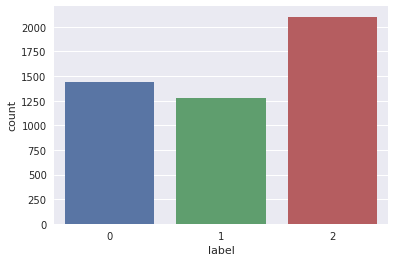

In [32]:
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=results)

A good way to visualize clusters is by using a scatter plot. It plots each data point in a two dimensional graph that allows you to visualize them as different groups. To do this, you need to convert your data points into sets of 2 (x and y coordinates) so they can be plotted. We use the dimensionality reduction technique [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) for this. Then we use it as an input to a scatter plot with color coding for the labels.

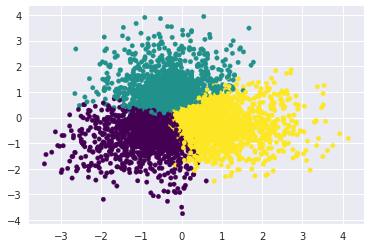

In [33]:
data=pd.read_csv(transform_input,header=None)
labels=results['label']
pca = PCA(n_components=2)
new_data= pca.fit_transform(data)
plt.scatter(new_data[:, 0], new_data[:, 1], c=labels, s=20, cmap='viridis')

Looking at the three clusters, we see there is a clear saperation between the three groups with few datapoints overlapping in each region.
<br><br>
Let us now look at the first 10 terms in each of our clusters.

In [34]:
print ('Cluster 1')
print(results[results["label"]==0]['term'].head(10))
print('\nCluster 2')
print(results[results["label"]==1]['term'].head(10))
print('\nCluster 3')
print(results[results["label"]==2]['term'].head(10))

Cluster 1
0         drowsy
2          tired
7        anxiety
8     depression
13     dry mouth
16        sleepy
23     confusion
24          ADHD
25          calm
26         angry
Name: term, dtype: object

Cluster 2
4                     acne
5                  pimples
6             light period
9          sexually active
11             mood swings
18             nulliparous
19                spotting
27    uncomfortable cramps
29                  libido
31                  cramps
Name: term, dtype: object

Cluster 3
1              UTI
3            burns
10           itchy
12    side effects
14    constipation
15      bronchitis
17            pain
20             gas
21        shingles
22        tingling
Name: term, dtype: object


Examining the results of our plots and the terms in each cluster provides us with some important insights:
1. We were able to divide terms derived from unstructured drug reviews into 3 groups. 
2. Group 2 was the dominant group in our analysis.
3. Examining the terms in each group, we are able to see some patterns emmerge. Cluster 1 seems to contain adverse events related to mood and emotions, cluster 2 has terms realated to infections and cluster 3 has terms related to mental health.

## Finding drugs similar to each other based on adverse events
If you recall, the end goal for us was to find all the drugs that are similar to a given drug with respect to the adverse events they demonstrate, given only unstructured review data and the names of drugs as inputs. With all the analysis we have done so far, we will not be able to tie the adverse events groups back to the original drugs in our dataset.
<br><br>
For the sake of this analysis, we will only take the first 200 drugs in our raw data. We will loop through the list of topics for each drug and find the corresponding list of labels for them from the predictions generated by our model. The resulting data contains the drug name and a list of topics and labels associated with each drug. 

In [35]:
raw_data_new = pd.DataFrame(columns=['drugName','topics','labels'])
raw_data_new=raw_data_new[0:0]
for index,row in raw_data.head(200).iterrows():
    labels=[]
    
    drug = row['drugName']
    topics = [row['topic1'],row['topic2'],row['topic3'],row['topic4'],row['topic5']]
    
    for index,row in results.iterrows():
        if row['term'] in topics:
            labels.append(row['label'])
    raw_data_new=raw_data_new.append({'drugName': drug,'topics': topics, 'labels':list(set(labels))},ignore_index=True)

raw_data_new.head()

,drugName,topics,labels
0,Levonorgestrel,"[drowsy, UTI, tired, burns, drowsy]","[0, 2]"
1,Differin,"[acne, pimples, Pimples, acne, pimples]",[1]
2,Ethinyl estradiol / norethindrone,"[light period, anxiety, depression, sexually a...","[0, 1]"
3,Invokana,"[itchy, lost about 17 pounds, feel sooo much b...",[2]
4,Leuprolide,"[depression, mood swings, mood swings, mood sw...","[0, 1, 2]"


Next, we create a function `similar_to`. This function takes a drug name as input and returns a list of drugnames that have any one of the associated labels. For example, if a drug contains labels [0,1], the function will return the names of all drugs that have either [0],[1] or [0,1] as labels.

In [ ]:
def similar_to(drug_name):
    import itertools
    drugnames=[]
    label= raw_data_new[raw_data_new['drugName']==drug_name]['labels']
    label_list = list(itertools.chain(*label))
    for index,row in raw_data_new.iterrows():
        if row['drugName']!=drug_name and any(elem in label_list  for elem in row['labels']):
            drugnames.append(row['drugName'])
            
    return drugnames

Lets now call the above function with a cetain drug name. The output will give you a list of drugs that are similar to the drug in the input. Here is an example.

In [ ]:
check_drug = 'Remeron'
output=similar_to(check_drug)
print ("\n\n\nWe found ",len(output),"drugs similar to ",check_drug," from a total of ",len(raw_data_new)," drugs included in this analysis!")
print("\n-------------------------------------------------------------------------------------------------------\n")
print(columnize.columnize(output, displaywidth=150, ljust=True))

## Conclusion
We have now achieved our goal of grouping drugs that are similar to each other based on the adverse events they had. We only had the unstructured adverse events data and drug names for this analysis. This opens the door to many important downstream analysis. The data from this algorithm can be used for correlative study of drug adverse events. In general, if there are drugs that are prescribed for a certain disease have similar adverse effects to drugs for a totally different disease, then they can be analyzed together. This could also be useful for supervised learning algorithms like classification which depend on labeled data.
<br>
We will now proceed to the third and final section of our workshop that will demonstrate a method to tune our clustering model. **Execute the next notebook `2.AE_Clustering_Automatic_Model_Tuning.ipynb`** 